In [1]:
import cv2
import numpy as np
import glob
import os
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display

%matplotlib inline

from LaneDetection import LaneDetection
from Camera import Camera

In [2]:
lka = LaneDetection()

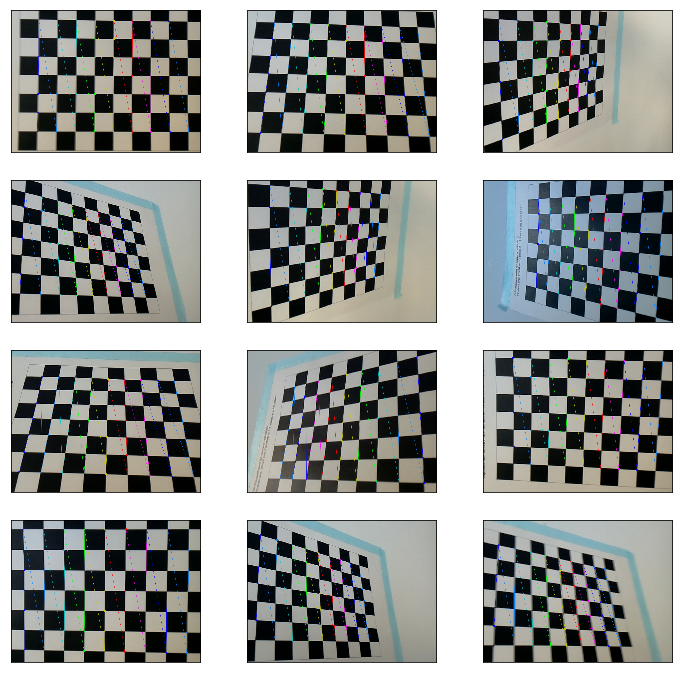

In [4]:
imgSize = (640, 480)

calChessboardPattern = (7, 9)
calImgsPath = glob.glob("./cam-calibration-images/*.png")

objPoints = []
imgPoints = []

objPt = np.zeros((calChessboardPattern[0] * calChessboardPattern[1], 3), np.float32)
objPt[:, :2] = np.mgrid[0:calChessboardPattern[0], 0:calChessboardPattern[1]].T.reshape(-1, 2)

fig = plt.figure(figsize=(12, 12))
# fig.suptitle("Part of sample chessboard images for camera calibration", fontsize=32)
columns = 3
rows = 4
i = 1

for image in calImgsPath:
    calImg = cv2.imread(image)
    ret, corners = cv2.findChessboardCorners(calImg, calChessboardPattern)
    
    if ret:
        imgPoints.append(corners)
        objPoints.append(objPt)
        cv2.drawChessboardCorners(calImg, calChessboardPattern, corners, ret)
        if i <= rows * columns:
            sub_i = fig.add_subplot(rows, columns, i)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(calImg,  cmap='gray')
            i += 1
        else:
            break
plt.show()

In [5]:
retval, cameraMatrix, distCoeffs, rvecs, tvecs = cv2.calibrateCamera(objPoints, imgPoints, imgSize, None, None)

print("Camera matrix: \n", cameraMatrix)
print("\nDistortion coefficients: \n", distCoeffs)

Camera matrix: 
 [[1.56954928e+03 0.00000000e+00 6.41568929e+02]
 [0.00000000e+00 1.56149767e+03 4.39386748e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Distortion coefficients: 
 [[ 0.07008744 -0.22942752  0.00151653  0.00225271 -0.00072445]]


In [6]:
optimAlpha = 1
optimCameraMatrix, cameraROI = cv2.getOptimalNewCameraMatrix(cameraMatrix, distCoeffs, imgSize, optimAlpha)
print("Optimal camera matrix: \n", optimCameraMatrix)
print("\nRegion of interest:\n", cameraROI)

Optimal camera matrix: 
 [[1.56839392e+03 0.00000000e+00 6.41568388e+02]
 [0.00000000e+00 1.56051062e+03 4.39418953e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Region of interest:
 (2, 2, 638, 478)


In [7]:
def undistortImage(img):
    imgUndistRaw = imgUndist = cv2.undistort(img, cameraMatrix, distCoeffs, None, optimCameraMatrix)
    x, y, w, h = cameraROI
    x, y, w, h = int(x), int(y), int(w), int(h)
    imgUndistCrop = imgUndist[y:y + h, x:x + w]
    imgUndistScaled = cv2.resize(imgUndistCrop, imgSize)
    return imgUndistScaled, imgUndistCrop, imgUndistRaw

True

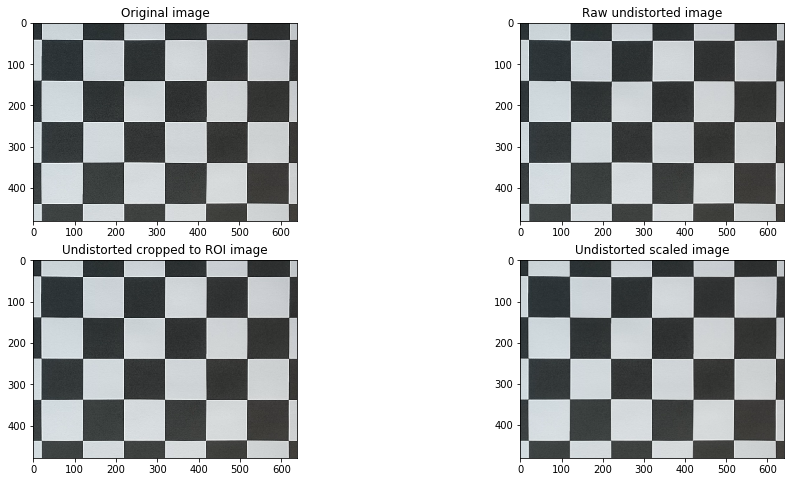

In [8]:
testImg = cv2.imread("./double_chessboard.png")
testUndistScaled, testUndistCrop, testUndistRaw = undistortImage(testImg)
fig = plt.figure(figsize=(16, 8))

sub1 = fig.add_subplot(2, 2, 1)
sub1.set_title("Original image")
plt.imshow(testImg)


sub2 = fig.add_subplot(2, 2, 2)
sub2.set_title("Raw undistorted image")
plt.imshow(testUndistRaw)
cv2.imwrite("./double_chessboard_undist_raw.png", testUndistRaw)

sub3 = fig.add_subplot(2, 2, 3)
sub3.set_title("Undistorted cropped to ROI image")
plt.imshow(testUndistCrop)
cv2.imwrite("./double_chessboard_undist_roi.png", testUndistCrop)

           
sub4 = fig.add_subplot(2, 2, 4)
sub4.set_title("Undistorted scaled image")
plt.imshow(testUndistScaled)
cv2.imwrite("./double_chessboard_result.png", testUndistScaled)

[[-4.38506338e-01 -1.59263066e+00  4.63884892e+02]
 [-9.02276490e-16 -2.87769784e+00  6.73381295e+02]
 [-1.34572488e-18 -4.92938982e-03  1.00000000e+00]]


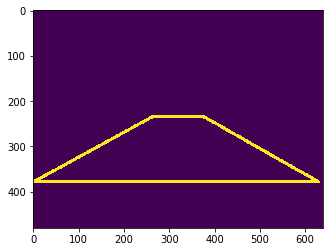

In [9]:
print(lka.camera.perspective_transform_matrix)
def drawWarpLines(img, imgWarped):
    for i in range(4):
        cv2.line(img, tuple(lka.camera.perspective_src_points[i]), tuple(lka.camera.perspective_src_points[(i + 1) % 4]), (255, 0, 0), thickness=5)
        cv2.line(imgWarped, tuple(lka.camera.perspective_dst_points[i]), tuple(lka.camera.perspective_dst_points[(i + 1) % 4]), (255, 0, 0), thickness=5)
    return img, imgWarped

blackOrg = np.zeros(imgSize[::-1])
blackWarp = np.zeros(imgSize[::-1])
blackOrg, blackWarp = drawWarpLines(blackOrg, blackWarp)


plt.imshow(blackOrg)
# fig = plt.figure(figsize=(16, 8))
# fig.add_subplot(1, 2, 1).axis('off')
# plt.imshow(blackOrg)
# fig.add_subplot(1, 2, 2).axis('off')
# plt.imshow(blackWarp)

In [10]:
print(lka.camera.perspective_src_points)
print(lka.camera.perspective_dst_points)

[[  0. 378.]
 [630. 378.]
 [376. 234.]
 [264. 234.]]
[[160. 480.]
 [480. 480.]
 [480.   0.]
 [160.   0.]]


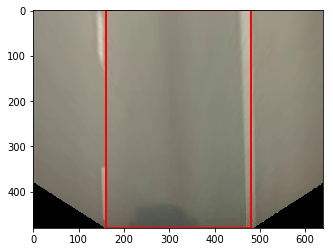

In [11]:
img_path = './test-videos/motorway-tests/snapshots/snap_4.png'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_trans = lka.camera.perspective_transform(img)
for i in range(4):
    cv2.line(img, tuple(lka.camera.perspective_src_points[i]), tuple(lka.camera.perspective_src_points[(i + 1) % 4]), (255, 0, 0), thickness=3)
    cv2.line(img_trans, tuple(lka.camera.perspective_dst_points[i]), tuple(lka.camera.perspective_dst_points[(i + 1) % 4]), (255, 0, 0), thickness=3)

plt.imshow(img)
plt.imshow(img_trans)

In [12]:
srcWarpPoints = np.float32([[0, 378], [630, 378],
                        [390, 234], [295, 234]])

dstWarpPoints = np.float32([[160, 480], [480, 480], [480, 0], [160, 0]])

warpMatrix = cv2.getPerspectiveTransform(srcWarpPoints, dstWarpPoints)

imgs_2 = glob.glob("./test-videos/motorway-tests-2/snapshots/*.png")

def warp_2(img):
    img_warped = cv2.warpPerspective(img, warpMatrix, (640, 480))
    return img_warped

for img in imgs_2:
    imgRead = cv2.imread(img)
#     imgRead = cv2.cvtColor(imgRead, cv2.COLOR_BGR2RGB)
    imgRead = lka.camera.undistort(imgRead)
    img2 = warp_2(imgRead)
    cv2.imwrite("./test-videos/motorway-tests-2/snapshots/transformed/" + os.path.basename(img), img2)  
    
imgs_2 = glob.glob("./test-videos/motorway-tests/snapshots/*.png")
for img in imgs_2:
    imgRead = cv2.imread(img)
#     imgRead = cv2.cvtColor(imgRead, cv2.COLOR_BGR2RGB)
    imgRead = lka.camera.undistort(imgRead)
    img2 = lka.camera.perspective_transform(imgRead)
    cv2.imwrite("./test-videos/motorway-tests/snapshots/transformed/" + os.path.basename(img), img2)  

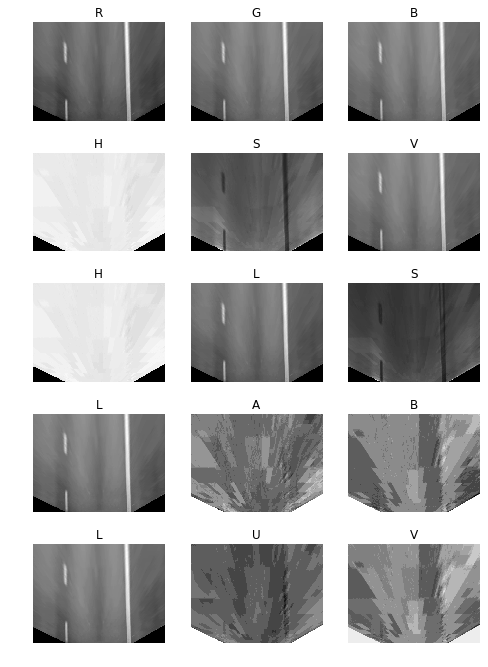

In [61]:
img_path = "./test-videos/motorway-tests-2/snapshots/transformed/snap_3.png"

fig = plt.figure(figsize=(8, 14))
columns = 3
rows = 6
# imgRGB = cv2.imread(image)
# imgBGR = cv2.imread("./samples/road_samples_1/warped/yellow_white_sample_warped.png")
imgBGR = cv2.imread(img_path)
imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
# imgRGB = lka.camera.undistort(imgRGB_org)
# imgRGB = lka.camera.perspective_transform(imgRGB)


imgRGB_R, imgRGB_G, imgRGB_B = cv2.split(imgRGB)

imgHSV = cv2.cvtColor(imgRGB, cv2.COLOR_RGB2HSV)
imgHSV_H, imgHSV_S, imgHSV_V = cv2.split(imgHSV)

imgHLS = cv2.cvtColor(imgRGB, cv2.COLOR_RGB2HLS)
imgHLS_H, imgHLS_L, imgHLS_S = cv2.split(imgHLS)

imgLUV = cv2.cvtColor(imgRGB, cv2.COLOR_RGB2LUV)
imgLUV_L, imgLUV_U, imgLUV_V = cv2.split(imgLUV)

imgLAB = cv2.cvtColor(imgRGB, cv2.COLOR_RGB2LAB)
imgLAB_L, imgLAB_A, imgLAB_B = cv2.split(imgLAB)

# subOrg = fig.add_subplot(rows, columns, 2)
# subOrg.axis('off')
# subOrg.set_title('Obraz oryginalny\ntransformowany')
# plt.imshow(imgRGB)

subRGB_R = fig.add_subplot(rows, columns, 1)
subRGB_R.axis('off')
subRGB_R.set_title('R')
plt.imshow(imgRGB_R, cmap='gray')
subRGB_G = fig.add_subplot(rows, columns, 2)
subRGB_G.axis('off')
subRGB_G.set_title('G')
plt.imshow(imgRGB_G, cmap='gray')
subRGB_B = fig.add_subplot(rows, columns, 3)
subRGB_B.axis('off')
subRGB_B.set_title('B')
plt.imshow(imgRGB_B, cmap='gray')

subHSV_H = fig.add_subplot(rows, columns, 4)
subHSV_H.axis('off')
subHSV_H.set_title('H')
plt.imshow(imgHSV_H, cmap='gray')
subHSV_S = fig.add_subplot(rows, columns, 5)
subHSV_S.axis('off')
subHSV_S.set_title('S')
plt.imshow(imgHSV_S, cmap='gray')
subHSV_V = fig.add_subplot(rows, columns, 6)
subHSV_V.axis('off')
subHSV_V.set_title('V')
plt.imshow(imgHSV_V, cmap='gray')

subHLS_H = fig.add_subplot(rows, columns, 7)
subHLS_H.axis('off')
subHLS_H.set_title('H')
plt.imshow(imgHLS_H, cmap='gray')
subHLS_L = fig.add_subplot(rows, columns, 8)
subHLS_L.axis('off')
subHLS_L.set_title('L')
plt.imshow(imgHLS_L, cmap='gray')
subHLS_S = fig.add_subplot(rows, columns, 9)
subHLS_S.axis('off')
subHLS_S.set_title('S')
plt.imshow(imgHLS_S, cmap='gray')

subLAB_L = fig.add_subplot(rows, columns, 10)
subLAB_L.axis('off')
subLAB_L.set_title('L')
plt.imshow(imgLAB_L, cmap='gray')
subLAB_A = fig.add_subplot(rows, columns, 11)
subLAB_A.axis('off')
subLAB_A.set_title('A')
plt.imshow(imgLAB_A, cmap='gray')
subLAB_B = fig.add_subplot(rows, columns, 12)
subLAB_B.axis('off')
subLAB_B.set_title('B')
plt.imshow(imgLAB_B, cmap='gray')

subLUV_L = fig.add_subplot(rows, columns, 13)
subLUV_L.axis('off')
subLUV_L.set_title('L')
plt.imshow(imgLUV_L, cmap='gray')
subLUV_U = fig.add_subplot(rows, columns, 14)
subLUV_U.axis('off')
subLUV_U.set_title('U')
plt.imshow(imgLUV_U, cmap='gray')
subLUV_V = fig.add_subplot(rows, columns, 15)
subLUV_V.axis('off')
subLUV_V.set_title('V')
plt.imshow(imgLUV_V, cmap='gray')

plt.show()

In [79]:
sampleRoadImgs = glob.glob("./test-videos/motorway-snapshots/*.png")

f=open("colors_output.txt", "w+")

imgList = []
for img in sampleRoadImgs:
    print(os.path.basename(img))
    imgRead = cv2.imread(img)
    imgRGB = cv2.cvtColor(imgRead, cv2.COLOR_BGR2RGB)
    imgRGB_R, imgRGB_G, imgRGB_B = cv2.split(imgRGB)
    
    imgHSV = cv2.cvtColor(imgRGB, cv2.COLOR_RGB2HSV)
    imgHSV_H, imgHSV_S, imgHSV_V = cv2.split(imgHSV)

    imgHLS = cv2.cvtColor(imgRGB, cv2.COLOR_RGB2HLS)
    imgHLS_H, imgHLS_L, imgHLS_S = cv2.split(imgHLS)

    imgLUV = cv2.cvtColor(imgRGB, cv2.COLOR_RGB2LUV)
    imgLUV_L, imgLUV_U, imgLUV_V = cv2.split(imgLUV)

    imgLAB = cv2.cvtColor(imgRGB, cv2.COLOR_RGB2LAB)
    imgLAB_L, imgLAB_A, imgLAB_B = cv2.split(imgLAB)
    
    imgGray = cv2.cvtColor(imgRGB, cv2.COLOR_RGB2GRAY)
    colors = [imgRGB_R, imgRGB_G, imgRGB_B, imgHSV_H, imgHSV_S, imgHSV_V, imgHLS_H, imgHLS_L, imgHLS_S, 
         imgLAB_L, imgLAB_A, imgLAB_B, imgLUV_L, imgLUV_U, imgLUV_V, imgGray]
    imgList.append(colors)

for i in range(len(imgList[0])):
#     f.write("Img %d\n" % i)
    for thresh in range(256):
        f.write("%d," % thresh)
        for color_layer in imgList:
            _, imgThresh = cv2.threshold(color_layer[i], thresh, 255, cv2.THRESH_BINARY)
            sum_ones = len(np.nonzero(imgThresh)[0])
            f.write("%d," % sum_ones)
        f.write("\n")
    f.write("\n")

    i += 1
f.close()
# _, imgThresh = cv2.threshold(imgRGB_R, 100, 255, cv2.THRESH_BINARY)
# print(len(np.nonzero(imgThresh)[0]))

snap_5_trans.png
snap_4_trans.png
snap_3_trans.png
snap_2_trans.png


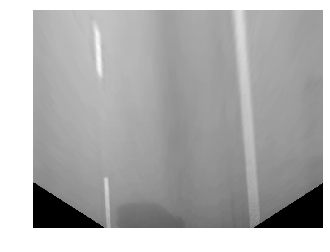

In [78]:
imgBGR = cv2.imread("./test-videos/motorway-tests/snapshots/transformed/snap_5.png")
img_gray = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2GRAY)
plt.axis('off')
plt.imshow(img_gray, cmap='gray')

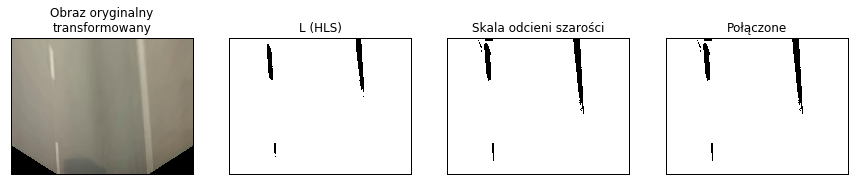

In [149]:
imgBGR = cv2.imread("./test-videos/motorway-tests/snapshots/transformed/snap_5.png")
imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
imgHLS = cv2.cvtColor(imgRGB, cv2.COLOR_RGB2HLS)
_, L, _ = cv2.split(imgHLS)
imgGray = cv2.cvtColor(imgRGB, cv2.COLOR_RGB2GRAY)

_, l_thresh = cv2.threshold(L, 166, 255, cv2.THRESH_BINARY)
l_, gray_thresh = cv2.threshold(imgGray, 167, 255, cv2.THRESH_BINARY)

combined_thresh = cv2.bitwise_or(l_thresh, gray_thresh)
fig = plt.figure(figsize=(15, 4))

subplot_thresh_0 = fig.add_subplot(1, 4, 1)
# subplot_thresh_1.axis('off')
subplot_thresh_0.set_title('Obraz oryginalny\ntransformowany')
plt.xticks([])
plt.yticks([])
plt.imshow(imgRGB)

subplot_thresh_1 = fig.add_subplot(1, 4, 2)
# subplot_thresh_1.axis('off')
subplot_thresh_1.set_title('L (HLS)')
plt.xticks([])
plt.yticks([])
plt.imshow(l_thresh, cmap='gray_r')

subplot_thresh_2 = fig.add_subplot(1, 4, 3)
plt.xticks([])
plt.yticks([])
subplot_thresh_2.set_title('Skala odcieni szarości')
plt.imshow(gray_thresh, cmap='gray_r')

subplot_thresh_3 = fig.add_subplot(1, 4, 4)
plt.xticks([])
plt.yticks([])
subplot_thresh_3.set_title('Połączone')
plt.imshow(combined_thresh, cmap='gray_r')

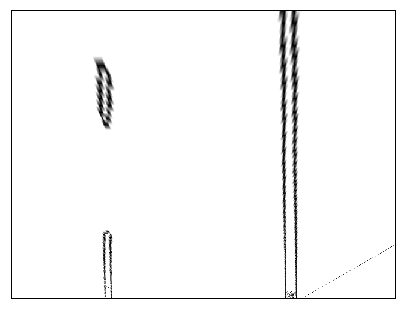

In [200]:
def cannyEdgeDetect(img, threshLow, threshHigh):
    img.dtype='uint8'
#     imgBlur = cv2.GaussianBlur(img, (3, 3), 0)
    imgGray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(imgGray, threshLow, threshHigh, (3, 3))
    return edges

imgRaw = cv2.imread("./test-videos/motorway-tests-2/snapshots/snap_3.png")
imgRaw = cv2.cvtColor(imgRaw, cv2.COLOR_BGR2RGB)

def setHighT_Canny(highThresh):
    return highThresh

def setLowT_Canny(lowThresh):
    edges = cannyEdgeDetect(imgRaw, lowThresh, wCanny_high.result)
    edgesWarped = lka.camera.perspective_transform(edges)
#     plt.imshow(edgesWarped)
    return lowThresh


edges = cannyEdgeDetect(imgRaw, 60, 150)
# edges = lka.camera.perspective_transform(edges)
edges = warp_2(edges)

fig = plt.figure()
ax = fig.add_axes((1, 1, 1, 1))
plt.xticks([])
plt.yticks([])
# plt.rcParams["axes.edgecolor"] = "black"
# plt.rcParams["axes.linewidth"] = 1
plt.imshow(edges, cmap='gray_r')

# wCanny_high = interactive(setHighT_Canny, highThresh=widgets.IntSlider(min=0,max=255,step=1,value=150))
# wCanny_low = interactive(setLowT_Canny, lowThresh=widgets.IntSlider(min=0,max=255,step=1,value=50))
# display(wCanny_high, wCanny_low)

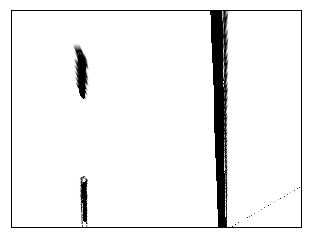

In [201]:
imgBGR = cv2.imread("./test-videos/motorway-tests-2/snapshots/transformed/snap_3.png")
imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)
imgHLS = cv2.cvtColor(imgRGB, cv2.COLOR_RGB2HLS)
_, L, _ = cv2.split(imgHLS)
imgGray = cv2.cvtColor(imgRGB, cv2.COLOR_RGB2GRAY)

_, l_thresh = cv2.threshold(L, 105, 255, cv2.THRESH_BINARY)
l_, gray_thresh = cv2.threshold(imgGray, 105, 255, cv2.THRESH_BINARY)

combined_thresh = cv2.bitwise_or(l_thresh, gray_thresh)



combined_thresh = cv2.bitwise_or(combined_thresh, edges)

plt.xticks([])
plt.yticks([])
plt.imshow(combined_thresh, cmap='gray_r')

308.0830025911817
320.0


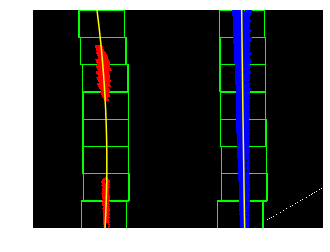

In [202]:
# imgBGR = cv2.imread("./test-videos/motorway-tests/snapshots/transformed/snap_4.png")
# imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)

# imgHLS = cv2.cvtColor(imgRGB, cv2.COLOR_RGB2HLS)
# _, L, _ = cv2.split(imgHLS)
# imgGray = cv2.cvtColor(imgRGB, cv2.COLOR_RGB2GRAY)

# _, l_thresh = cv2.threshold(L, 164, 255, cv2.THRESH_BINARY)
# l_, gray_thresh = cv2.threshold(imgGray, 164, 255, cv2.THRESH_BINARY)

# combined_thresh = cv2.bitwise_or(l_thresh, gray_thresh)



# img_udist = lka.camera.undistort(snap_img)
# img_trans = lka.camera.perspective_transform(img_udist)
# img_bin = lka.get_lane_binary_image(img_trans, img_udist)
# plt.imshow(combined_thresh)



edges[edges!=0] = 1
combined_thresh[combined_thresh!=0] = 1

img_bin = cv2.bitwise_or(combined_thresh, edges)


image_size = lka.camera.get_image_size()
histogram = np.sum(img_bin[np.int(image_size[1] / 2):, :], axis=0)
# out_img = np.dstack((img_bin, img_bin, img_bin)) * 255
mid_x = np.int(image_size[0] / 2)

# average starting base for left and right line
left_x_base = np.int(np.argmax(histogram[:mid_x]))
right_x_base = np.int(np.argmax(histogram[mid_x:]) + mid_x)

margin = 50
windows_num = 8

window_height = np.int(image_size[1] / windows_num)

nonzero = img_bin.nonzero()
nonzero_y = np.array(nonzero[0])
nonzero_x = np.array(nonzero[1])

left_x_current, right_x_current = left_x_base, right_x_base

# least pixels amount for rect to be change next position
pixels_thresh = 10

left_lane_pix = []
right_lane_pix = []

out_img = np.dstack((img_bin, img_bin, img_bin))*255

for window in range(windows_num):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = img_bin.shape[0] - (window + 1) * window_height
    win_y_high = img_bin.shape[0] - window * window_height
    win_x_left_low = left_x_current - margin
    win_x_left_high = left_x_current + margin
    win_x_right_low = right_x_current - margin
    win_x_right_high = right_x_current + margin
    

    # print(win_y_low, win_y_high, win_x_left_low, win_x_left_high, win_x_right_low, win_x_right_high)
    # Draw the windows on the visualization image
    cv2.rectangle(out_img, (win_x_left_low, win_y_low), (win_x_left_high, win_y_high), (0, 255, 0), 2)
    cv2.rectangle(out_img, (win_x_right_low, win_y_low), (win_x_right_high, win_y_high), (0, 255, 0), 2)

    # Identify the nonzero pixels in x and y within the window
    good_left_ids = ((nonzero_y >= win_y_low) & (nonzero_y < win_y_high) & (nonzero_x >= win_x_left_low) & (
                nonzero_x < win_x_left_high)).nonzero()[0]
    good_right_ids = ((nonzero_y >= win_y_low) & (nonzero_y < win_y_high) & (nonzero_x >= win_x_right_low) & (
                nonzero_x < win_x_right_high)).nonzero()[0]

    # Append these indices to the lists
    left_lane_pix.append(good_left_ids)
    right_lane_pix.append(good_right_ids)
    


    # If you found pixels > pixels_thresh, recenter next window on their mean position
    if len(good_left_ids) > pixels_thresh:
        left_x_current = np.int(np.mean(nonzero_x[good_left_ids]))
    if len(good_right_ids) > pixels_thresh:
        right_x_current = np.int(np.mean(nonzero_x[good_right_ids]))

left_lane_pix = np.concatenate(left_lane_pix)
right_lane_pix = np.concatenate(right_lane_pix)

# Extract left and right line pixel positions
left_x = nonzero_x[left_lane_pix]
left_y = nonzero_y[left_lane_pix]
right_x = nonzero_x[right_lane_pix]
right_y = nonzero_y[right_lane_pix]

# Color in left and right line pixels
out_img[left_y, left_x] = [255, 0, 0]
out_img[right_y, right_x] = [0, 0, 255]

left_fit_coeffs = np.array([0, 0, 0])
right_fit_coeffs = np.array([0, 0, 0])

# Fit a second order polynomial to each
if left_x.size == 0 or left_y.size == 0 or right_x.size == 0 or right_y.size == 0:
    ret = False

else:
    left_fit_coeffs = np.polyfit(left_y, left_x, 2)
    right_fit_coeffs = np.polyfit(right_y, right_x, 2)
    ret = True

    # if right_fit_coeffs[2] - left_fit_coeffs[2] < 0.9 * (self.camera.perspective_dst_points[1][0] - self.camera.perspective_dst_points[0][0]):
    #     ret = False

# print(left_fit_coeffs, right_fit_coeffs)


# Generate x and y values for plotting
if ret:
    fit_y = np.linspace(0, image_size[1] - 1, image_size[1])
    left_fit_x = left_fit_coeffs[0] * fit_y ** 2 + left_fit_coeffs[1] * fit_y + left_fit_coeffs[2]
    right_fit_x = right_fit_coeffs[0] * fit_y ** 2 + right_fit_coeffs[1] * fit_y + right_fit_coeffs[2]
    
#     # Draw the lane onto the warped blank image
#     cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
#     cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    
    base_width = right_fit_x[-1] - left_fit_x[-1]
    nominal_width = lka.camera.perspective_dst_points[1][0] - lka.camera.perspective_dst_points[0][0]
    
    print(base_width)
    print(nominal_width)

#     if base_width < 0.95 * nominal_width or base_width > 1.05 * nominal_width:
#         ret = False
#     print(curves_difference(left_fit_x, right_fit_x))
#     print(curves_inter_area(left_fit_x, right_fit_x))
#     print(nominal_width * lka.camera.get_image_size()[1])
    plt.axis('off')
    plt.imshow(out_img)
    plt.plot(left_fit_x, fit_y, color='yellow')
    plt.plot(right_fit_x, fit_y, color='yellow')

else:
    fit_y = None
    left_fit_x = None
    right_fit_x = None
    
    


[[  0. 378.]
 [630. 378.]
 [376. 234.]
 [264. 234.]]


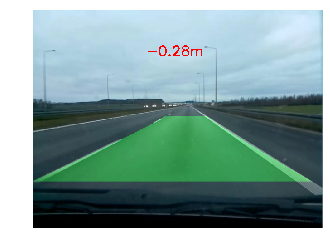

In [9]:
imgBGR = cv2.imread("./test-videos/motorway-tests-2/snapshots/snap_3.png")
imgRGB = cv2.cvtColor(imgBGR, cv2.COLOR_BGR2RGB)

result, _, _ = lka.process(imgRGB)
# result = lka.camera.mark_roi(imgRGB)
plt.axis('off')
plt.imshow(result)
print(lka.camera.perspective_src_points)